In [15]:
install.packages("performance")
library(DHARMa)
library(lindia)
library(tidyverse)
library(caret)
library(leaps)
library(MASS)
library(modEvA)
library(dplyr)
library(broom)
library(ggpubr) 
library(rstatix)
library(WRS2) #robust ancova

library(lme4) #random effect
library(lmerTest) #like lmer but with p-value
library(robustlmm) #robust (with weight) linear mixed effect models

library(rstanarm) #r2 in mixed effect models
library(performance) #r2 in mixed effect models

Warning message:
"package 'performance' is in use and will not be installed"


In [17]:
R.version

               _                           
platform       x86_64-w64-mingw32          
arch           x86_64                      
os             mingw32                     
system         x86_64, mingw32             
status                                     
major          4                           
minor          0.3                         
year           2020                        
month          10                          
day            10                          
svn rev        79318                       
language       R                           
version.string R version 4.0.3 (2020-10-10)
nickname       Bunny-Wunnies Freak Out     

install.packages("WRS", repos="http://R-Forge.R-project.org", type="source")
library(WRS)

## Download data

In [2]:
path_ = 'G:/VPHI/Welfare/2- Research Projects/OFHE2.OriginsE2/DataOutput/TrackingSystem/chapter0_final_/Cleaning/Raw&Cleaned'
#path_ = 'C:/Users/camil/Desktop'
name = 'df4DifferenceModelling'
#name = 'df4DifferenceModelling_4lowerDF'
#name = 'df4DifferenceModelling_mixedHenID'
sink(file.path(path_,paste(name,'.txt', sep='')))
df = read.csv(file.path(path_, paste(name,'.csv', sep='')), header = TRUE, sep = ";")
df$PenID = as.factor(df$PenID)
df$tracking_system = as.factor(df$tracking_system)
df$Trackingsystem_Zone = as.factor(df$Trackingsystem_Zone)
df$HenID = as.factor(df$HenID)
df$level = as.factor(df$level)
df$level_continuous = as.integer(df$level_continuous)
df$absolute_difference_log_1 = log(df$absolute_difference+1) #add one then take the log
df$absolute_difference_log_0 = log(df$absolute_difference+0.1) #add one then take the log
df$absolute_difference_sqrt = sqrt(df$absolute_difference)
#print(as.data.frame(table(df$maxsevGap0_divided_maxsev_round)))
print(dim(df))
summary(df)

[1] 40735    14


 absolute_difference     PenID                  tracking_system 
 Min.   : 0.000      Pen 8  :5200   TrackingSystem 10-12:15035  
 1st Qu.: 0.000      Pen 9  :5200   TrackingSystem 3-5  :15300  
 Median : 1.000      Pen 11 :5100   TrackingSystem 8-9  :10400  
 Mean   : 3.145      Pen 3  :5100                               
 3rd Qu.: 4.000      Pen 4  :5100                               
 Max.   :70.000      Pen 5  :5100                               
                     (Other):9935                               
       Trackingsystem_Zone     HenID              level       level_continuous
 nbr_stays_1_Zone:8147     hen_1  :  260   2020-11-26:  795   Min.   : 0.00   
 nbr_stays_2_Zone:8147     hen_105:  260   2020-11-27:  795   1st Qu.:12.00   
 nbr_stays_3_Zone:8147     hen_106:  260   2020-11-28:  795   Median :27.00   
 nbr_stays_4_Zone:8147     hen_113:  260   2020-11-29:  795   Mean   :26.23   
 nbr_stays_5_Zone:8147     hen_116:  260   2020-11-30:  795   3rd Qu.:40.00   
      

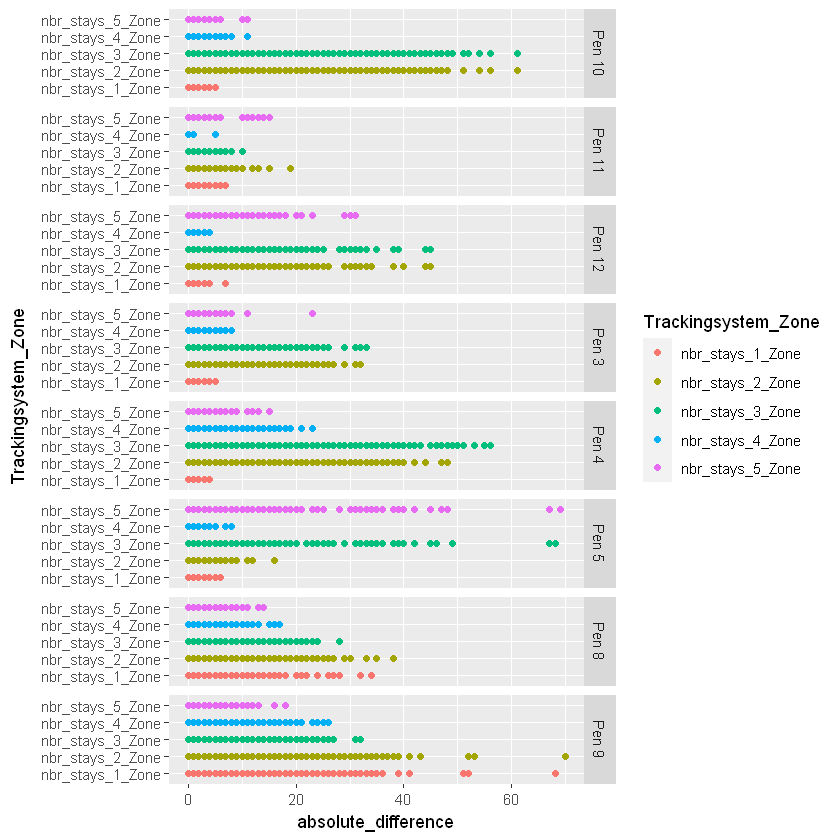

In [3]:
ggplot(df, aes(y = Trackingsystem_Zone, x = absolute_difference, col=Trackingsystem_Zone)) + geom_point() + facet_grid(PenID ~ .)
ggsave(path = path_, width = 9, height = 6, device='tiff', filename=paste('visualisation_basics_',name,'.jpg', sep=''), dpi=700)

# Model

In [4]:
fit = lmer(absolute_difference_log_0 ~ PenID*Trackingsystem_Zone + humidity_avgpercent + temperature_C + (1|HenID)+(1|level), data = df)
#Hence, this boils down to comparing the variation between different PenID (having 7 degrees of freedom) to the variation 
#due to the interaction between Trackingsystem_Zone and HenID (having  5*159=795  degrees of freedom).
capture.output(summary(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
summary(fit)


Correlation matrix not shown by default, as p = 42 > 12.
Use print(item$value, correlation=TRUE)  or
    vcov(item$value)        if you need it



Correlation matrix not shown by default, as p = 42 > 12.
Use print(obj, correlation=TRUE)  or
    vcov(obj)        if you need it




Linear mixed model fit by REML. t-tests use Satterthwaite's method [
lmerModLmerTest]
Formula: 
absolute_difference_log_0 ~ PenID * Trackingsystem_Zone + humidity_avgpercent +  
    temperature_C + (1 | HenID) + (1 | level)
   Data: df

REML criterion at convergence: 132502.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.9962 -0.6139 -0.0465  0.6315  4.5544 

Random effects:
 Groups   Name        Variance Std.Dev.
 HenID    (Intercept) 0.43854  0.6622  
 level    (Intercept) 0.01815  0.1347  
 Residual             1.47967  1.2164  
Number of obs: 40735, groups:  HenID, 159; level, 52

Fixed effects:
                                                  Estimate Std. Error
(Intercept)                                     -1.853e+00  2.172e-01
PenIDPen 11                                      1.628e-01  2.162e-01
PenIDPen 12                                      2.197e-02  2.191e-01
PenIDPen 3                                      -5.040e-02  2.162e-01
PenIDPen 4               

In [5]:
#from: https://easystats.github.io/performance/index.html
capture.output(r2(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
r2(fit)

# R2 for Mixed Models

  Conditional R2: 0.615
     Marginal R2: 0.496

In [6]:
r2(fit, by_group = FALSE, tolerance = 1e-05)

# R2 for Mixed Models

  Conditional R2: 0.615
     Marginal R2: 0.496

In [7]:
#rand: Likelihood Ratio Test On Random Effects Of Linear Mixed Effects Model
#tests the hypothesis that the random effect variation is significant versus the null that there is no between group-level 
capture.output(rand(fit), file=file.path(path_,paste(name,'.txt', sep='')), append=TRUE)
#variation
rand(fit)

,npar,logLik,AIC,LRT,Df,Pr(>Chisq)
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
<none>,45,-66251.12,132592.2,NA,NA,NA
(1 | HenID),44,-71001.56,142091.1,9500.8760,1,0.000000e+00
(1 | level),44,-66430.11,132948.2,357.9753,1,7.770792e-80


In [8]:
ranef(fit)

$HenID
         (Intercept)
hen_1    1.065789132
hen_10   0.576982329
hen_101 -0.455510307
hen_102 -0.821536211
hen_105  0.749286272
hen_106  0.778689691
hen_107  0.758340667
hen_108 -0.420643048
hen_109  0.040511861
hen_111 -0.006924933
hen_112 -0.330144194
hen_113  0.172033818
hen_115  0.432178892
hen_116 -1.322753536
hen_118  0.138980528
hen_119 -0.369930524
hen_12   0.686322670
hen_120  0.402110208
hen_122 -0.277130216
hen_123 -0.460254950
hen_124 -0.399734788
hen_126 -0.454764736
hen_127  1.129820729
hen_128 -0.178323811
hen_13   0.341714647
hen_131 -0.026120470
hen_134  0.249253980
hen_135  0.160948539
hen_136 -1.453517159
hen_137 -0.075893628
hen_138  0.353641994
hen_139 -0.084876807
hen_14  -0.530485651
hen_140  0.578876716
hen_141 -0.337646653
hen_142  0.140905865
hen_143  0.141544690
hen_144 -0.336565779
hen_145 -1.030547748
hen_146 -1.672264289
hen_147  1.081656662
hen_149 -0.145110437
hen_15  -0.834303690
hen_150  1.440418107
hen_151  0.089471689
hen_152 -1.305635069
hen_15

In [9]:
#linearity #todooooooooooo run it!!!
jpeg(file.path(path_, paste('diagnostic_plot_linearity_',name,'.jpg', sep='')))
plot(resid(fit),df$absolute_difference_log_0)
dev.off()

png 
  2

In [10]:
#check homogeneity of variance
#variance of the residuals is equal across groups
jpeg(file.path(path_, paste('diagnostic_plot_homo-var_',name,'.jpg', sep='')))
plot(fit)
dev.off()

png 
  2

In [11]:
#normally distributed residuals
#qqmath(fit) #same
jpeg(file.path(path_, paste('diagnostic_plot_normal-resid_',name,'.jpg', sep='')))
qqnorm(resid(fit))
dev.off()

png 
  2

$HenID

$level


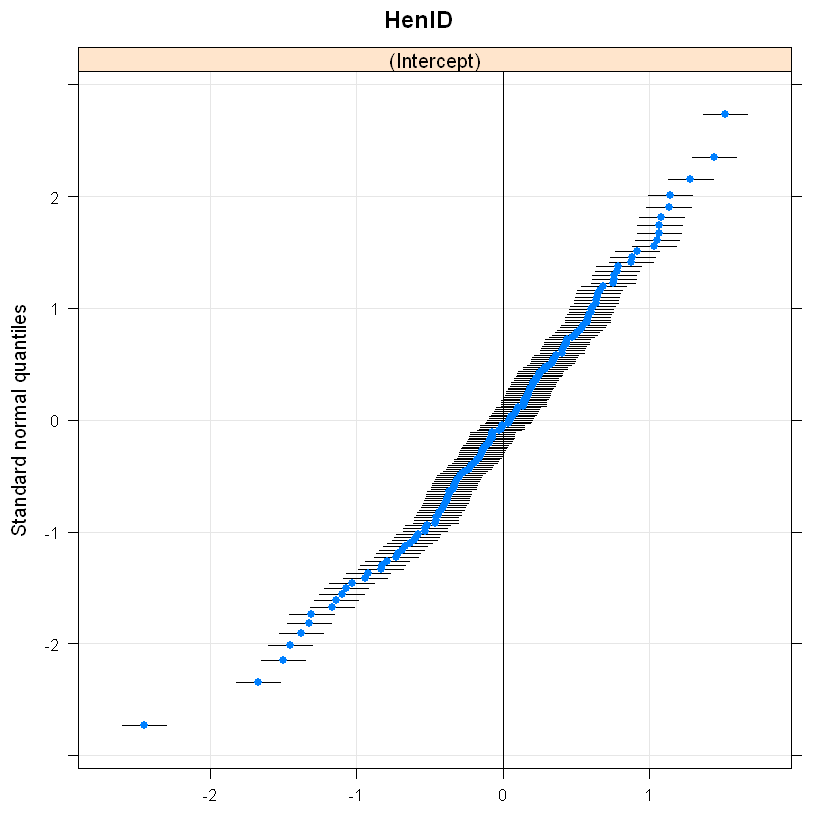

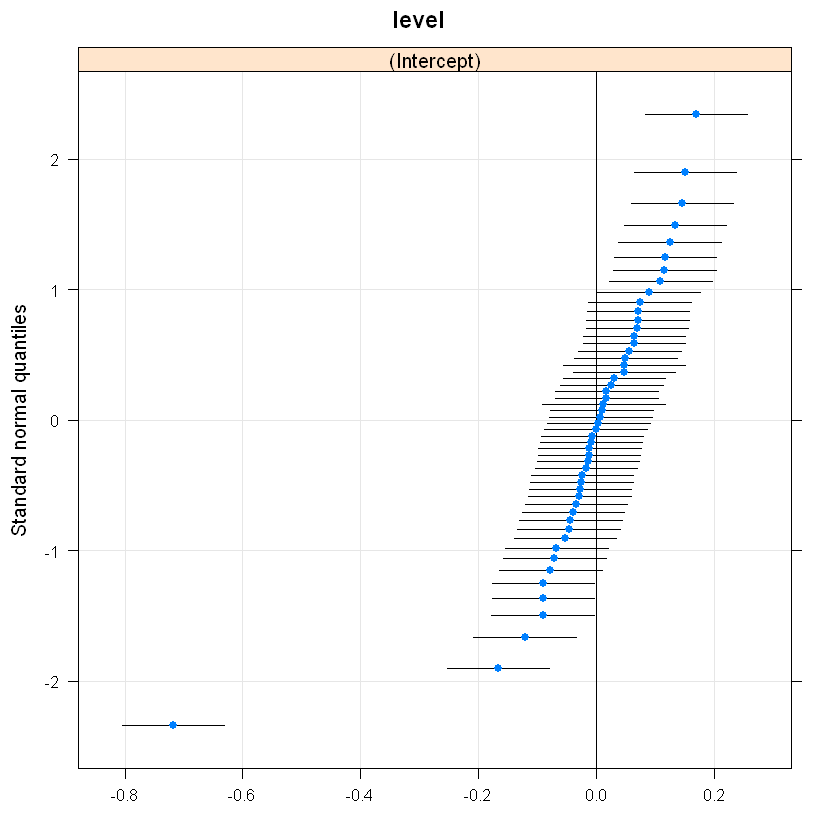

In [12]:
#qqplot
qqmath(ranef(fit))

In [13]:
#TODO: TOREAD: https://stat.ethz.ch/~meier/teaching/anova/random-and-mixed-effects-models.html